In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random

# =================================================================
# 1Îã®Í≥Ñ: ÌååÏùº Î°úÎìú Î∞è Í∏∞Î≥∏ Ï†ÑÏ≤òÎ¶¨
# =================================================================
WINDOW_SIZE = 3
FILE_PATH = '../DB/factory_sample_20pct.csv'

try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"Ïò§Î•ò: '{FILE_PATH}' ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
    exit()

df['event_time'] = pd.to_datetime(df['event_time'])

# =================================================================
# 2Îã®Í≥Ñ: Îã®Ïñ¥Ïû• ÏÉùÏÑ±
# =================================================================
unique_event_types = df['event_type'].unique().tolist()
event_type_vocab = ['<PAD>', '<UNK>'] + unique_event_types
event_type_to_idx = {etype: i for i, etype in enumerate(event_type_vocab)}
print("--- ÏÉùÏÑ±Îêú Îã®Ïñ¥Ïû• (ÏÇ¨Ï†Ñ) ---")
print(f"Ï¥ù Îã®Ïñ¥ Ïàò: {len(event_type_to_idx)}")
# print(event_type_to_idx) # Îã®Ïñ¥Ïû•Ïù¥ Í∏∏Î©¥ Ï£ºÏÑù Ï≤òÎ¶¨
print("-" * 35)

# =================================================================
# 3Îã®Í≥Ñ: ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§ Î∞è EPC Íº¨Î¶¨Ìëú ÏÉùÏÑ±
# =================================================================
sequence_set_text = []
epc_for_each_sequence = []

grouped = df.groupby('epc_code')
for epc, group_df in grouped:
    sorted_group = group_df.sort_values(by='event_time').reset_index(drop=True)
    processed_group = sorted_group[['location_id', 'event_type', 'event_time']]
    if len(processed_group) < WINDOW_SIZE:
        pad_len = WINDOW_SIZE - len(processed_group)
        padding_df = pd.DataFrame({'location_id': [0] * pad_len, 'event_type': ['<PAD>'] * pad_len, 'event_time': pd.to_datetime([pd.NaT] * pad_len)})
        padded_sequence = pd.concat([padding_df, processed_group], ignore_index=True)
        sequence_set_text.append(padded_sequence)
        epc_for_each_sequence.append(epc)
    else:
        num_windows = len(processed_group) - WINDOW_SIZE + 1
        for i in range(num_windows):
            window = processed_group.iloc[i : i + WINDOW_SIZE].reset_index(drop=True)
            sequence_set_text.append(window)
            epc_for_each_sequence.append(epc)

print(f"‚úÖ 3Îã®Í≥Ñ: ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§ ÏÉùÏÑ± ÏôÑÎ£å. Ï¥ù {len(sequence_set_text)}Í∞ú")

# =================================================================
# 4Îã®Í≥Ñ: ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§Î•º Ïà´Ïûê ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôò (Î™®Îç∏ ÏûÖÎ†•Ïö©)
# =================================================================
sequence_set_processed = []
unk_idx = event_type_to_idx['<UNK>']

for seq_df in sequence_set_text:
    df_copy = seq_df.copy()
    mapped_series = df_copy['event_type'].map(event_type_to_idx)
    df_copy['event_type'] = mapped_series.fillna(unk_idx).astype(int)
    
    def time_to_tan(t):
        if pd.isna(t): return 0.0
        seconds_in_day = 86400
        seconds_from_midnight = t.hour * 3600 + t.minute * 60 + t.second
        normalized_time = seconds_from_midnight / seconds_in_day
        return np.tan((normalized_time - 0.5) * np.pi)

    df_copy['time_tan'] = df_copy['event_time'].apply(time_to_tan)
    final_df = df_copy[['location_id', 'event_type', 'time_tan']]
    sequence_set_processed.append(final_df)
    
print(f"‚úÖ 4Îã®Í≥Ñ: Ïà´Ïûê ÏãúÌÄÄÏä§ Î≥ÄÌôò ÏôÑÎ£å. Ï¥ù {len(sequence_set_processed)}Í∞ú")

# =================================================================
# 5Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ (Train / Test Split)
# =================================================================
indices = np.arange(len(sequence_set_processed))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_sequences_processed = [sequence_set_processed[i] for i in train_indices]
test_sequences_text = [sequence_set_text[i] for i in test_indices]
test_epcs = [epc_for_each_sequence[i] for i in test_indices]

print(f"\n‚úÖ 5Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ ÏôÑÎ£å")
print(f"ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Ïàò: {len(train_sequences_processed)}")
print(f"ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïàò: {len(test_sequences_text)}")

# =================================================================
# 6Îã®Í≥Ñ: ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± (ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã Í∏∞Î∞ò)
# =================================================================
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò Ï†àÎ∞òÏùÑ ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞Î°ú ÎßåÎì≠ÎãàÎã§.
n_anomalies_to_create = len(test_sequences_text) // 2

generated_anomalies_text = []
all_event_types = [event for event in event_type_to_idx.keys() if event not in ['<PAD>', '<UNK>']]

for i in range(n_anomalies_to_create):
    normal_sequence_df = test_sequences_text[i].copy()
    real_data_mask = normal_sequence_df['event_type'] != '<PAD>'
    real_data_indices = normal_sequence_df[real_data_mask].index
    if len(real_data_indices) < 2: continue

    anomaly_type = random.choice(['shuffle', 'replace', 'time'])
    anomaly_df = normal_sequence_df.copy()

    if anomaly_type == 'shuffle':
        shuffled_events = anomaly_df.loc[real_data_indices, 'event_type'].sample(frac=1).values
        anomaly_df.loc[real_data_indices, 'event_type'] = shuffled_events
    elif anomaly_type == 'replace':
        replace_idx = random.choice(real_data_indices)
        original_event = anomaly_df.loc[replace_idx, 'event_type']
        possible_replacements = [e for e in all_event_types if e != original_event]
        if not possible_replacements: continue
        new_event = random.choice(possible_replacements)
        anomaly_df.loc[replace_idx, 'event_type'] = new_event
    elif anomaly_type == 'time':
        last_event_idx = real_data_indices[-1]
        anomaly_df.loc[last_event_idx, 'event_time'] += pd.to_timedelta('30D')

    generated_anomalies_text.append(anomaly_df)

print(f"\n‚úÖ 6Îã®Í≥Ñ: ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏôÑÎ£å")
print(f"Ï¥ù {len(generated_anomalies_text)}Í∞úÏùò ÎπÑÏ†ïÏÉÅ ÏãúÌÄÄÏä§Í∞Ä ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.")

# =================================================================
# 7Îã®Í≥Ñ: ÏµúÏ¢Ö ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± (X_train, y_train)
# =================================================================
# "Ï†ïÏÉÅ ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ (train_sequences_processed)"Îßå ÏÇ¨Ïö©ÌïòÏó¨ NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôòÌï©ÎãàÎã§.
X_location_list = [seq['location_id'].values for seq in train_sequences_processed]
X_event_type_list = [seq['event_type'].values for seq in train_sequences_processed]
X_time_tan_list = [seq['time_tan'].values for seq in train_sequences_processed]

X_location_np = np.array(X_location_list)
X_event_type_np = np.array(X_event_type_list)
X_time_tan_np = np.array(X_time_tan_list)[..., np.newaxis]

X_train = [X_location_np, X_event_type_np, X_time_tan_np]
y_train = [X_location_np, X_event_type_np, X_time_tan_np]

print(f"\n‚úÖ ÏµúÏ¢Ö Îã®Í≥Ñ: ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± ÏôÑÎ£å")
print("Ïù¥Ï†ú Î™®Îç∏ÏùÑ ÌïôÏäµÏãúÌÇ¨ Ï§ÄÎπÑÍ∞Ä ÎêòÏóàÏäµÎãàÎã§.")
print(f"Location Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: {X_location_np.shape}")
print(f"Event Type Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: {X_event_type_np.shape}")
print(f"Time Tan Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: {X_time_tan_np.shape}")

--- ÏÉùÏÑ±Îêú Îã®Ïñ¥Ïû• (ÏÇ¨Ï†Ñ) ---
Ï¥ù Îã®Ïñ¥ Ïàò: 12
-----------------------------------
‚úÖ 3Îã®Í≥Ñ: ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§ ÏÉùÏÑ± ÏôÑÎ£å. Ï¥ù 118426Í∞ú
‚úÖ 4Îã®Í≥Ñ: Ïà´Ïûê ÏãúÌÄÄÏä§ Î≥ÄÌôò ÏôÑÎ£å. Ï¥ù 118426Í∞ú

‚úÖ 5Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ ÏôÑÎ£å
ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Ïàò: 94740
ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïàò: 23686

‚úÖ 6Îã®Í≥Ñ: ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏôÑÎ£å
Ï¥ù 11843Í∞úÏùò ÎπÑÏ†ïÏÉÅ ÏãúÌÄÄÏä§Í∞Ä ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.

‚úÖ ÏµúÏ¢Ö Îã®Í≥Ñ: ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± ÏôÑÎ£å
Ïù¥Ï†ú Î™®Îç∏ÏùÑ ÌïôÏäµÏãúÌÇ¨ Ï§ÄÎπÑÍ∞Ä ÎêòÏóàÏäµÎãàÎã§.
Location Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: (94740, 3)
Event Type Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: (94740, 3)
Time Tan Îç∞Ïù¥ÌÑ∞ ÌòïÌÉú: (94740, 3, 1)


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, RepeatVector, TimeDistributed

# Î™®Îç∏ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
# LOCATION_VOCAB_SIZE = df['location_id'].nunique() + 1
LOCATION_VOCAB_SIZE = df['location_id'].max() + 1
EVENT_TYPE_VOCAB_SIZE = len(event_type_to_idx)
EMBEDDING_DIM = 8
LATENT_DIM = 8

# 1. ÏûÖÎ†•Ï∏µ
input_location = Input(shape=(WINDOW_SIZE,), name='input_location')
input_event_type = Input(shape=(WINDOW_SIZE,), name='input_event_type')
input_time_tan = Input(shape=(WINDOW_SIZE, 1), name='input_time_tan')

# 2. ÏûÑÎ≤†Îî© Î∞è Í≤∞Ìï©
embedding_location = Embedding(input_dim=LOCATION_VOCAB_SIZE, output_dim=EMBEDDING_DIM)(input_location)
embedding_event_type = Embedding(input_dim=EVENT_TYPE_VOCAB_SIZE, output_dim=EMBEDDING_DIM)(input_event_type)
concatenated_inputs = Concatenate()([embedding_location, embedding_event_type, input_time_tan])

# 3. Ïù∏ÏΩîÎçî
encoder_lstm = LSTM(LATENT_DIM, activation='relu')(concatenated_inputs)

# 4. ÎîîÏΩîÎçî
repeat_vector = RepeatVector(WINDOW_SIZE)(encoder_lstm)
decoder_lstm = LSTM(EMBEDDING_DIM * 2 + 1, activation='relu', return_sequences=True)(repeat_vector)

# 5. Ï∂úÎ†•Ï∏µ
output_location = TimeDistributed(Dense(LOCATION_VOCAB_SIZE, activation='softmax'), name='output_location')(decoder_lstm)
output_event_type = TimeDistributed(Dense(EVENT_TYPE_VOCAB_SIZE, activation='softmax'), name='output_event_type')(decoder_lstm)
output_time_tan = TimeDistributed(Dense(1), name='output_time_tan')(decoder_lstm)

# 6. Î™®Îç∏ ÏÉùÏÑ±
autoencoder = Model(inputs=[input_location, input_event_type, input_time_tan],
                    outputs=[output_location, output_event_type, output_time_tan])

print("\n‚úÖ 3Îã®Í≥Ñ: Ïò§ÌÜ†Ïù∏ÏΩîÎçî Î™®Îç∏ Íµ¨Ï∂ï ÏôÑÎ£å")
autoencoder.summary()


‚úÖ 3Îã®Í≥Ñ: Ïò§ÌÜ†Ïù∏ÏΩîÎçî Î™®Îç∏ Íµ¨Ï∂ï ÏôÑÎ£å


Model: "functional_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_location      ‚îÇ (None, 3)         ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ input_event_type    ‚îÇ (None, 3)         ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding_6         ‚îÇ (None, 3, 8)      ‚îÇ      1,272 ‚îÇ input_location[0‚Ä¶ ‚îÇ
‚îÇ (Embedding)         ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding_7         ‚îÇ (None, 3, 8)      ‚îÇ         96 ‚îÇ input_event_type‚Ä¶ ‚îÇ
‚îÇ (Embedding)         ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ input_time_tan      ‚îÇ (None, 3, 1)      ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ concatenate_3       ‚îÇ (None, 3, 17)     ‚îÇ          0 ‚îÇ embedding_6[0][0‚Ä¶ ‚îÇ
‚îÇ (Concatenate)       ‚îÇ                   ‚îÇ            ‚îÇ embedding_7[0][0‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ                   ‚îÇ            ‚îÇ input_time_tan[0‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_6 (LSTM)       ‚îÇ (None, 8)         ‚îÇ        832 ‚îÇ concatenate_3[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ repeat_vector_3     ‚îÇ (None, 3, 8)      ‚îÇ          0 ‚îÇ lstm_6[0][0]      ‚îÇ
‚îÇ (RepeatVector)      ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_7 (LSTM)       ‚îÇ (None, 3, 17)     ‚îÇ      1,768 ‚îÇ repeat_vector_3[‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚

 Total params: 7,064 (27.59 KB)

 Trainable params: 7,064 (27.59 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Í∞Å Ï∂úÎ†•Ïóê ÎßûÎäî ÏÜêÏã§ Ìï®Ïàò ÏßÄÏ†ï
losses = {
    'output_location': 'sparse_categorical_crossentropy',
    'output_event_type': 'sparse_categorical_crossentropy',
    'output_time_tan': 'mean_squared_error'
}

autoencoder.compile(optimizer='adam', loss=losses)

print("\n‚úÖ 4Îã®Í≥Ñ: Î™®Îç∏ ÌïôÏäµ ÏãúÏûë")
history = autoencoder.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

print("\nüéâ Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å!")


‚úÖ 4Îã®Í≥Ñ: Î™®Îç∏ ÌïôÏäµ ÏãúÏûë
Epoch 1/50
1333/1333 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 4ms/step - loss: 129.1034 - output_event_type_loss: 2.1848 - output_location_loss: 3.7531 - output_time_tan_loss: 123.1656 - val_loss: 6.5173 - val_output_event_type_loss: 1.2846 - val_output_location_loss: 2.2533 - val_output_time_tan_loss: 2.9581
Epoch 2/50
1333/1333 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 4ms/step - loss: 6.3294 - output_event_type_loss: 1.1234 - output_location_loss: 2.0707 - output_time_tan_loss: 3.1353 - val_loss: 2.9981 - val_output_event_type_loss: 0.7476 - val_output_location_loss: 1.5151 - val_output_time_tan_loss: 0.7175
Epoch 3/50
1333/1333 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 4ms/step - loss: 2.7986 - output_event_type_loss: 0.6993 - output_location_loss: 1.4433 - output_time_tan_loss: 0.6560 - val_loss: 2.6842 - val_output_event_type_loss: 0.5918 - val_output_location_loss: 1.2598 - val_


‚úÖ 8Îã®Í≥Ñ: Î™®Îç∏ ÌèâÍ∞Ä ÏãúÏûë
ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Íµ¨ÏÑ± ÏôÑÎ£å. (Ï†ïÏÉÅ: 11843Í∞ú, ÎπÑÏ†ïÏÉÅ: 11843Í∞ú)
741/741 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step

Î™®Îç∏ AUC Ï†êÏàò: 0.7922
ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í: 1.6842


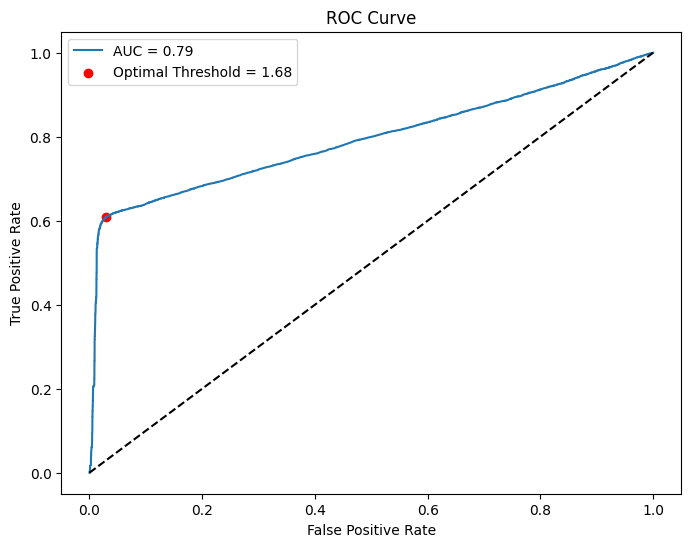


--- Classification Report ---
              precision    recall  f1-score   support

  Normal (0)       0.71      0.97      0.82     11843
 Anomaly (1)       0.95      0.61      0.74     11843

    accuracy                           0.79     23686
   macro avg       0.83      0.79      0.78     23686
weighted avg       0.83      0.79      0.78     23686



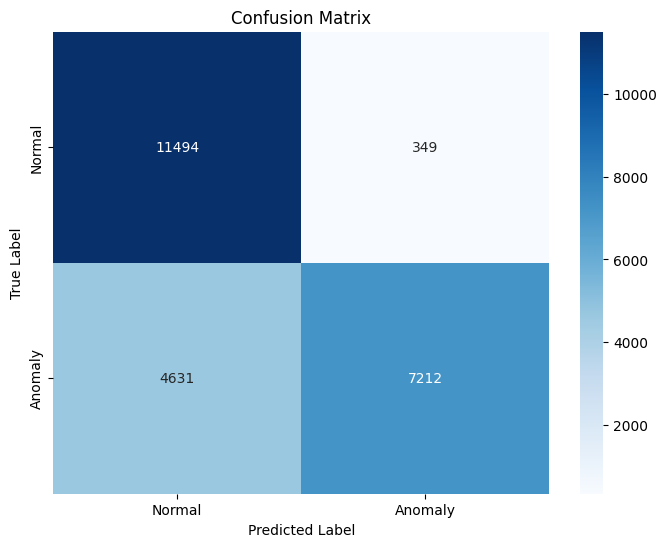


--- Î™®Îç∏Ïù¥ 'ÎπÑÏ†ïÏÉÅ'ÏúºÎ°ú ÌÉêÏßÄÌïú Ïù¥Îèô Î™©Î°ù (ÏÉÅÏúÑ 10Í∞ú) ---
                                           epc_code  from_location  \
6423  001.8804823.1293291.010004.20250701.000004035             59   
285   001.8805843.3812382.010003.20250701.000003523             68   
3623  001.8809437.1203199.100002.20250701.000001916             35   
563   001.8805843.3812382.010003.20250701.000003523             68   
1996  001.8809437.1203199.100002.20250701.000001494             35   
6606  001.8809437.1203199.100002.20250701.000001662             35   
1376  001.8809437.1203199.100002.20250701.000001304             35   
3627  001.8804823.1293291.010004.20250701.000005013             23   
65    001.8805843.3812382.010003.20250701.000003661             59   
3323  001.8804823.1293291.150004.20250701.000004773             41   

      to_location  reconstruction_error      is_correct  
6423           59           1700.349365   True Positive  
285            68           1531.2182

In [16]:
# =================================================================
# 8Îã®Í≥Ñ: Î™®Îç∏ ÌèâÍ∞Ä Î∞è Ïù¥ÏÉÅ ÌÉêÏßÄ Í≤∞Í≥º Î∂ÑÏÑù
# =================================================================
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

print("\n‚úÖ 8Îã®Í≥Ñ: Î™®Îç∏ ÌèâÍ∞Ä ÏãúÏûë")

# --- 1. ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± (Ï†ïÏÉÅ + ÎπÑÏ†ïÏÉÅ) ---
# ÌÖåÏä§Ìä∏ÏÖãÏóêÏÑú ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±Ïóê ÏÇ¨Ïö©ÎêòÏßÄ ÏïäÏùÄ ÎÇòÎ®∏ÏßÄ 'Ï†ïÏÉÅ' Îç∞Ïù¥ÌÑ∞
n_anomalies_created = len(generated_anomalies_text)
normal_test_sequences_text = test_sequences_text[n_anomalies_created:]

# ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ÏÖã = (Ï†ïÏÉÅ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ + ÏÉùÏÑ±Îêú ÎπÑÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞)
final_test_sequences_text = normal_test_sequences_text + generated_anomalies_text
# Ï†ïÎãµ Î†àÏù¥Î∏î ÏÉùÏÑ± (Ï†ïÏÉÅ: 0, ÎπÑÏ†ïÏÉÅ: 1)
y_test_labels = [0] * len(normal_test_sequences_text) + [1] * len(generated_anomalies_text)

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÎèÑ Î™®Îç∏ ÏûÖÎ†•Ïóê ÎßûÍ≤å Ïà´Ïûê(processed) ÌòïÌÉúÎ°ú Î≥ÄÌôò
test_sequences_processed = []
for seq_df in final_test_sequences_text:
    df_copy = seq_df.copy()
    mapped_series = df_copy['event_type'].map(event_type_to_idx)
    df_copy['event_type'] = mapped_series.fillna(unk_idx).astype(int)
    
    def time_to_tan(t):
        if pd.isna(t): return 0.0
        seconds_in_day = 86400
        seconds_from_midnight = t.hour * 3600 + t.minute * 60 + t.second
        normalized_time = seconds_from_midnight / seconds_in_day
        return np.tan((normalized_time - 0.5) * np.pi)

    df_copy['time_tan'] = df_copy['event_time'].apply(time_to_tan)
    final_df = df_copy[['location_id', 'event_type', 'time_tan']]
    test_sequences_processed.append(final_df)

# NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
X_test_location = np.array([seq['location_id'].values for seq in test_sequences_processed])
X_test_event_type = np.array([seq['event_type'].values for seq in test_sequences_processed])
X_test_time_tan = np.array([seq['time_tan'].values for seq in test_sequences_processed])[..., np.newaxis]
X_test = [X_test_location, X_test_event_type, X_test_time_tan]

print(f"ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Íµ¨ÏÑ± ÏôÑÎ£å. (Ï†ïÏÉÅ: {y_test_labels.count(0)}Í∞ú, ÎπÑÏ†ïÏÉÅ: {y_test_labels.count(1)}Í∞ú)")


# --- 2. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú Ïû¨Íµ¨ÏÑ± Ïò§Î•ò Í≥ÑÏÇ∞ ---
predicted_test = autoencoder.predict(X_test)
predicted_loc, predicted_event, predicted_time = predicted_test

# Keras ÏÜêÏã§ Ìï®ÏàòÎ•º ÏßÅÏ†ë ÏûÑÌè¨Ìä∏ÌïòÏó¨ Ïò§Î•ò Í≥ÑÏÇ∞
# from tensorflow.keras.losses import sparse_categorical_crossentropy, mean_squared_error
# loc_errors = np.mean(sparse_categorical_crossentropy(X_test[0], predicted_loc), axis=1)
# event_errors = np.mean(sparse_categorical_crossentropy(X_test[1], predicted_event), axis=1)
# time_errors = np.mean(mean_squared_error(X_test[2], predicted_time), axis=(1, 2))
# total_test_errors = loc_errors + event_errors + time_errors
loc_errors = np.mean(tf.keras.losses.sparse_categorical_crossentropy(X_test[0], predicted_loc), axis=1)
event_errors = np.mean(tf.keras.losses.sparse_categorical_crossentropy(X_test[1], predicted_event), axis=1)
time_errors = np.mean(tf.keras.losses.mse(X_test[2], predicted_time), axis=1)
total_test_errors = loc_errors + event_errors + time_errors


# --- 3. ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í(Threshold) Ï∞æÍ∏∞ (ROC Ïª§Î∏å ÌôúÏö©) ---
fpr, tpr, thresholds = roc_curve(y_test_labels, total_test_errors)
auc_score = roc_auc_score(y_test_labels, total_test_errors)

# ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í: TPR - FPRÏù¥ ÏµúÎåÄÍ∞Ä ÎêòÎäî ÏßÄÏ†ê (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"\nÎ™®Îç∏ AUC Ï†êÏàò: {auc_score:.4f}")
print(f"ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í: {optimal_threshold:.4f}")

# ROC Ïª§Î∏å ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--') # 50% ÏÑ±Îä•ÏÑ†
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# --- 4. ÏµúÏ¢Ö ÏÑ±Îä• ÌèâÍ∞Ä (Classification Report & Confusion Matrix) ---
final_predictions = (total_test_errors > optimal_threshold).astype(int)

print("\n--- Classification Report ---")
print(classification_report(y_test_labels, final_predictions, target_names=['Normal (0)', 'Anomaly (1)']))

# Confusion Matrix ÏãúÍ∞ÅÌôî
cm = confusion_matrix(y_test_labels, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# --- 5. Î™®Îç∏Ïù¥ 'ÎπÑÏ†ïÏÉÅ'ÏúºÎ°ú ÌåêÎã®Ìïú Ïù¥Îèô Î∂ÑÏÑù ---
anomaly_indices = np.where(final_predictions == 1)[0]
test_normal_epcs = test_epcs[n_anomalies_created:]
generated_anomaly_epcs = test_epcs[:n_anomalies_created]
final_test_epcs = test_normal_epcs + generated_anomaly_epcs

anomalies_detected = []
for idx in anomaly_indices:
    detected_sequence_df = final_test_sequences_text[idx]
    
    real_data = detected_sequence_df[detected_sequence_df['event_type'] != '<PAD>']
    if len(real_data) < 2: continue

    from_event = real_data.iloc[-2]
    to_event = real_data.iloc[-1]
    
    anomalies_detected.append({
        'epc_code': final_test_epcs[idx],
        'from_location': int(from_event['location_id']),
        'to_location': int(to_event['location_id']),
        'reconstruction_error': total_test_errors[idx],
        'is_correct': 'True Positive' if y_test_labels[idx] == 1 else 'False Positive'
    })

anomaly_df = pd.DataFrame(anomalies_detected).sort_values(by='reconstruction_error', ascending=False)
print("\n--- Î™®Îç∏Ïù¥ 'ÎπÑÏ†ïÏÉÅ'ÏúºÎ°ú ÌÉêÏßÄÌïú Ïù¥Îèô Î™©Î°ù (ÏÉÅÏúÑ 10Í∞ú) ---")
print(anomaly_df.head(10))